In [1]:
%matplotlib inline  

import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
import xgboost as xgb
import matplotlib.pyplot as plt


Using TensorFlow backend.
/Users/vsokolov/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# ndcg5
def ndcg5(preds, y_true):
	k = 5
	n = len(y_true)
	num_class = preds.shape[1]
	index = np.argsort(preds, axis=1)
	top = index[:, -k:][:,::-1]
	rel = (np.reshape(y_true, (n, 1))==top).astype(int)
	cal_dcg = lambda y: sum((2**y - 1)/np.log2(range(2, k+2)))
	ndcg = np.mean((np.apply_along_axis(cal_dcg, 1, rel)))
	return 'ndcg5', -ndcg

In [3]:
print("Loading Data...")
with open("../data/airbnb/X.pickle", 'rb') as fh:
	X = pickle.load(fh)
# with open("../data/airbnb/X_test.pickle", 'rb') as fh:
# 	X_test = pickle.load(fh)
with open("../data/airbnb/y.pickle", 'rb') as fh:
	y = pickle.load(fh)

# n = X.shape[0]
# ind_train = np.random.choice(range(n), size=int(0.8*n))

Loading Data...


In [4]:
SS = preprocessing.StandardScaler()
X_std = SS.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_std, y, test_size=0.1, random_state=0)
label_train = np_utils.to_categorical(y_train)
label_val = np_utils.to_categorical(y_val)
num_class = max(y)+1

In [5]:
# a linear stack of layers
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1]))
model.add(Activation('relu'))
#model.add(Dropout(0.05))

model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.05))

model.add(Dense(num_class))
model.add(Activation('softmax'))

# multiclass logloss
model.compile(loss='categorical_crossentropy', optimizer='adagrad')

# fit
# a typical minibatch size is 256
# shuffle the samples at each epoch
model.fit(X_train, label_train, batch_size=128, nb_epoch=20, validation_data=(X_val, label_val), shuffle=True, verbose=2)

preds = model.predict_proba(X_val, verbose=0)

/Users/vsokolov/anaconda2/lib/python2.7/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 192105 samples, validate on 21346 samples
Epoch 1/20
3s - loss: 1.0647 - val_loss: 1.0333
Epoch 2/20
3s - loss: 1.0347 - val_loss: 1.0299
Epoch 3/20
3s - loss: 1.0292 - val_loss: 1.0279
Epoch 4/20
3s - loss: 1.0258 - val_loss: 1.0269
Epoch 5/20
3s - loss: 1.0235 - val_loss: 1.0253
Epoch 6/20
3s - loss: 1.0219 - val_loss: 1.0262
Epoch 7/20
3s - loss: 1.0205 - val_loss: 1.0252
Epoch 8/20
3s - loss: 1.0192 - val_loss: 1.0246
Epoch 9/20
3s - loss: 1.0179 - val_loss: 1.0265
Epoch 10/20
3s - loss: 1.0170 - val_loss: 1.0245
Epoch 11/20
3s - loss: 1.0162 - val_loss: 1.0232
Epoch 12/20
3s - loss: 1.0153 - val_loss: 1.0244
Epoch 13/20
3s - loss: 1.0145 - val_loss: 1.0242
Epoch 14/20
3s - loss: 1.0137 - val_loss: 1.0234
Epoch 15/20
3s - loss: 1.0130 - val_loss: 1.0235
Epoch 16/20
3s - loss: 1.0124 - val_loss: 1.0243
Epoch 17/20
3s - loss: 1.0117 - val_loss: 1.0241
Epoch 18/20
3s - loss: 1.0112 - val_loss: 1.0237
Epoch 19/20
3s - loss: 1.0106 - val_loss: 1.0235
Epoch 20/20
3s - loss: 1.01

In [6]:
ndcg5(preds, y_val)

('ndcg5', -0.83380895399747634)

In [7]:
train_users_path = '../data/airbnb/train_users.csv'
df_train = pd.read_csv(train_users_path)
target = df_train['country_destination']
le = LabelEncoder()
y = le.fit_transform(target.values)
y_val_inv = le.inverse_transform(y_val)
y_val_inv[1:20]

array(['CA', 'NDF', 'NDF', 'other', 'US', 'NDF', 'US', 'NDF', 'US', 'US',
       'NDF', 'NDF', 'NDF', 'NDF', 'FR', 'GB', 'NDF', 'NDF', 'US'], dtype=object)

In [8]:
def bar_data(preds, y_true):
    k = 5
    n = len(y_true)
    num_class = preds.shape[1]
    index = np.argsort(preds, axis=1)
    top = index[:, -k:][:,::-1]
    rel = (np.reshape(y_true, (n, 1))==top).astype(int)
    cal_dcg = lambda y: sum((2**y - 1)/np.log2(range(2, k+2)))
    return rel

In [9]:
a = bar_data(preds, y_val)

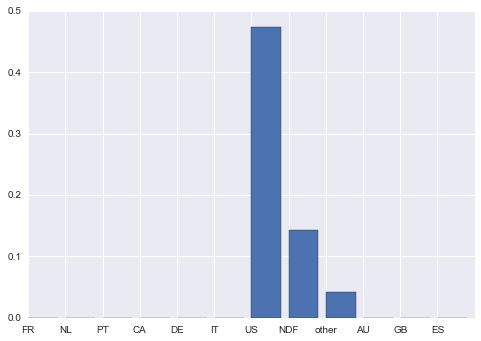

In [10]:
u_item = np.unique(y_val_inv)
d= {}
for item in u_item:
    ind = np.where(y_val_inv==item)
    y_val_inv[ind]
    d[item] = (a[ind,1]==1).mean()
d.values()
y_pos = np.arange(len(d.values()))

plt.bar(y_pos,d.values())
plt.xticks(y_pos, d.keys());

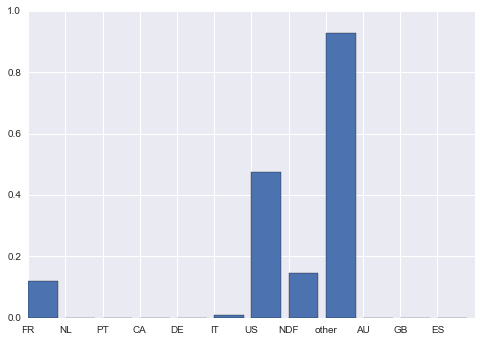

In [11]:
u_item = np.unique(y_val_inv)
d= {}
for item in u_item:
    ind = np.where(y_val_inv==item)
    y_val_inv[ind]
    d[item] = (a[ind,1]==1).mean() + (a[ind,2]==1).mean()
d.values()
y_pos = np.arange(len(d.values()))
plt.bar(y_pos,d.values())
plt.xticks(y_pos, d.keys());

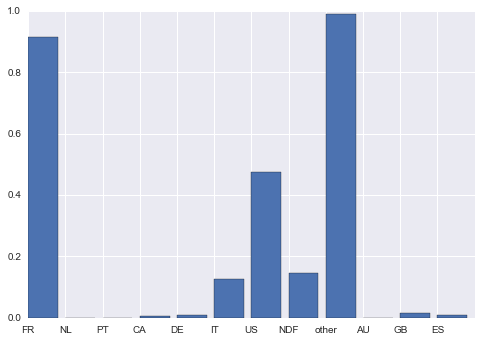

In [12]:
u_item = np.unique(y_val_inv)
d= {}
for item in u_item:
    ind = np.where(y_val_inv==item)
    y_val_inv[ind]
    d[item] = (a[ind,1]==1).mean() + (a[ind,2]==1).mean()+ (a[ind,3]==1).mean()
d.values()
y_pos = np.arange(len(d.values()))
plt.bar(y_pos,d.values())
plt.xticks(y_pos, d.keys());

AU 0.252974796215
CA 0.637121708985
DE 0.449732971048
ES 1.0353227771
FR 2.19713295231
GB 1.17117961211
IT 1.1992879228
NDF 58.9478122365
NL 0.313876136044
PT 0.112433242762
US 28.83444205
other 4.84868359412


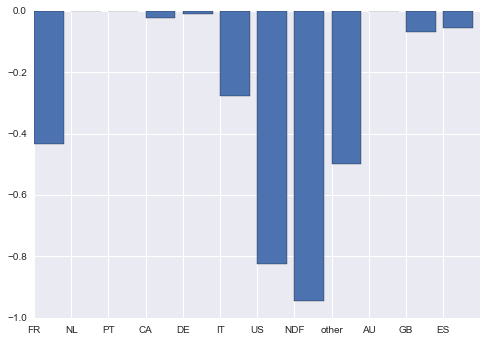

In [13]:
u_item = np.unique(y_val_inv)
d= {}
n = len(y_val) + 0.0
for item in u_item:
    ind = np.where(y_val_inv==item)
    print item, len(ind[0])/n*100
    d[item] = ndcg5(preds[ind], y_val[ind])[1]
y_pos = np.arange(len(d.values()))
plt.bar(y_pos,d.values())
plt.xticks(y_pos, d.keys());
